# COVID-19 Detection in Chest X-Ray Images
The goal of this project is to build a model that identifies COVID-19, pneumonia in chest X-Ray images. The dataset is organized into 3 folders (COVID-19 cases, Normal , Pneumonia) and contains subfolders for each image category. There are 606 X-Ray images (JPEG). Data from [Mendeley](https://data.mendeley.com/datasets/fvk7h5dg2p/1). 

In [1]:
# Download and unzip
dataroot = "dataroot/"
!mkdir dataroot 
!wget -P dataroot https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/fvk7h5dg2p-1.zip


--2021-04-21 17:54:39--  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/fvk7h5dg2p-1.zip
Resolving md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)... 52.218.52.235
Connecting to md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)|52.218.52.235|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198985388 (190M) [application/octet-stream]
Saving to: ‘dataroot/fvk7h5dg2p-1.zip’

fvk7h5dg2p-1.zip    100%[===================>] 189.77M  9.09MB/s    in 18s     

2021-04-21 17:54:58 (10.7 MB/s) - ‘dataroot/fvk7h5dg2p-1.zip’ saved [198985388/198985388]



In [5]:
# Unzip
import zipfile
with zipfile.ZipFile(dataroot+"fvk7h5dg2p-1.zip","r") as zip_ref:
    zip_ref.extractall(dataroot)

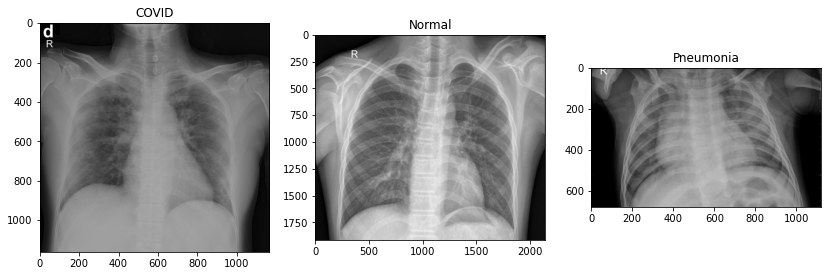

In [1]:
# Load and preview images
dataroot = "dataroot/"
import matplotlib.pyplot as plt
import numpy as np
import cv2

img_covid     = cv2.imread(dataroot+'COVID-19 cases/1-s2.0-S0929664620300449-gr2_lrg-d.jpg',0)
img_normal    = cv2.imread(dataroot+'Normal /IM-0011-0001-0001.jpeg',0)
img_pneumonia = cv2.imread(dataroot+'Pneumonia/person1650_virus_2854.jpeg',0)

plt.figure(figsize=(14,14))
plt.subplot(1,3,1)
plt.imshow(img_covid,cmap='gray')
plt.title('COVID')
plt.subplot(1,3,2)
plt.imshow(img_normal,cmap='gray')
plt.title('Normal')
plt.subplot(1,3,3)
plt.title('Pneumonia')
plt.imshow(img_pneumonia,cmap='gray')

plt.show()


Model mostly derived from sample code from TensorFlow website for image classification:
https://www.tensorflow.org/tutorials/images/classification

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorboard.plugins.hparams import api as hp

import datetime


In [3]:
%load_ext tensorboard

In [5]:
img_h = 512
img_w = 512

train_ds = keras.preprocessing.image_dataset_from_directory(
    dataroot,
    validation_split = 0.2,
    subset='training',
    color_mode='grayscale',
    seed=1234,
    image_size=(img_h, img_w)
)

Found 603 files belonging to 3 classes.
Using 483 files for training.


In [6]:
val_ds = keras.preprocessing.image_dataset_from_directory(
    dataroot,
    validation_split = 0.2,
    subset='validation',
    color_mode='grayscale',
    seed=1234,
    image_size=(img_h, img_w)
)

Found 603 files belonging to 3 classes.
Using 120 files for validation.


In [7]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['COVID-19 cases', 'Normal ', 'Pneumonia']


In [8]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([16,32]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
        hparams=[HP_NUM_UNITS, HP_OPTIMIZER],
        metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')]
    )

In [9]:
epochs=10
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

def build_model(hparams):
    model = tf.keras.models.Sequential([
        layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_h, img_w, 1)),
        layers.Conv2D(hparams[HP_NUM_UNITS], 1, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(2*hparams[HP_NUM_UNITS], 1, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(4*hparams[HP_NUM_UNITS], 1, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(8*hparams[HP_NUM_UNITS], activation='relu'),
        layers.Dense(num_classes)
    ])

    model.compile(optimizer=hparams[HP_OPTIMIZER],
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    model.fit(
        train_ds,
        epochs=epochs,
        callbacks=[callback]
    )

    _, accuracy = model.evaluate(val_ds)
    
    return accuracy

In [10]:
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)
        accuracy = build_model(hparams)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [12]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
    for optimizer in HP_OPTIMIZER.domain.values:
        hparams = {
            HP_NUM_UNITS: num_units,
            HP_OPTIMIZER: optimizer,
        }

        run_name = 'run-%d' % session_num
        print(f'--Starting Run: {run_name}')
        print({h.name: hparams[h] for h in hparams})
        run(f'logs/hparam_tuning/{run_name}', hparams)
        session_num += 1

--Starting Run: run-0
{'num_units': 16, 'optimizer': 'adam'}
Epoch 1/10
16/16 [==============================] - 24s 1s/step - loss: 5.0817 - accuracy: 0.3830
Epoch 2/10
16/16 [==============================] - 23s 1s/step - loss: 0.8328 - accuracy: 0.5406
Epoch 3/10
16/16 [==============================] - 27s 1s/step - loss: 0.6193 - accuracy: 0.6860
Epoch 4/10
16/16 [==============================] - 23s 1s/step - loss: 0.5003 - accuracy: 0.7532
Epoch 5/10
16/16 [==============================] - 23s 1s/step - loss: 0.4584 - accuracy: 0.8050
Epoch 6/10
16/16 [==============================] - 22s 1s/step - loss: 0.3471 - accuracy: 0.8715
Epoch 7/10
16/16 [==============================] - 25s 1s/step - loss: 0.2911 - accuracy: 0.9140
Epoch 8/10
16/16 [==============================] - 22s 1s/step - loss: 0.2661 - accuracy: 0.8886
Epoch 9/10
16/16 [==============================] - 22s 1s/step - loss: 0.2382 - accuracy: 0.9073
Epoch 10/10
4/4 [==============================] - 3s 215

In [13]:
#%tensorboard --logdir logs/hparam_tuning

In [14]:
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_h, img_w, 1)),
    layers.Conv2D(16, 1, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 1, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 1, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [15]:
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 512, 512, 1)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 512, 512, 16)      32        
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 256, 256, 16)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 256, 256, 32)      544       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 128, 128, 64)      2112      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 64, 64, 64)       

In [17]:
epochs = 25

callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=epochs,
    callbacks=[callback, tensorboard_callback]
)

Epoch 1/25
16/16 [==============================] - 25s 1s/step - loss: 3.8598 - accuracy: 0.4246 - val_loss: 0.8395 - val_accuracy: 0.6083
Epoch 2/25
16/16 [==============================] - 25s 1s/step - loss: 0.7428 - accuracy: 0.6152 - val_loss: 0.6831 - val_accuracy: 0.8000
Epoch 3/25
16/16 [==============================] - 25s 1s/step - loss: 0.5324 - accuracy: 0.7909 - val_loss: 0.4161 - val_accuracy: 0.8333
Epoch 4/25
16/16 [==============================] - 25s 1s/step - loss: 0.3936 - accuracy: 0.8276 - val_loss: 0.3712 - val_accuracy: 0.8250
Epoch 5/25
16/16 [==============================] - 25s 1s/step - loss: 0.3399 - accuracy: 0.8545 - val_loss: 0.3310 - val_accuracy: 0.8917
Epoch 6/25
16/16 [==============================] - 24s 1s/step - loss: 0.2906 - accuracy: 0.8950 - val_loss: 0.4536 - val_accuracy: 0.8417
Epoch 7/25
16/16 [==============================] - 28s 2s/step - loss: 0.2972 - accuracy: 0.8914 - val_loss: 0.2697 - val_accuracy: 0.8833
Epoch 8/25
16/16 [==

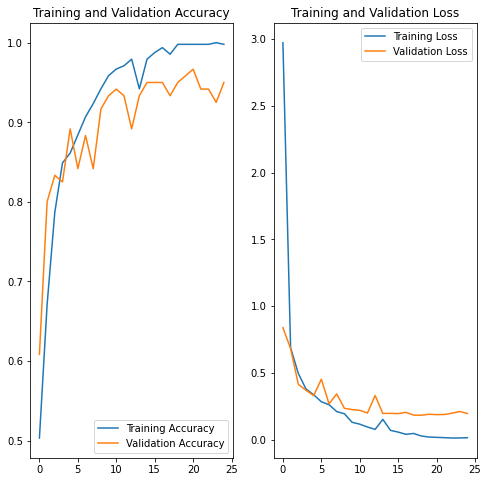

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
# 
#%tensorboard --logdir logs/fit

In [20]:
# Adding Dropout layer to see if it improves the model
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_h, img_w, 1)),
    layers.Conv2D(16, 1, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 1, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 1, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [21]:
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=epochs,
    callbacks=[callback, tensorboard_callback]
)

Epoch 1/25
16/16 [==============================] - 25s 1s/step - loss: 5.1208 - accuracy: 0.3811 - val_loss: 0.8161 - val_accuracy: 0.5667
Epoch 2/25
16/16 [==============================] - 27s 2s/step - loss: 0.7575 - accuracy: 0.5892 - val_loss: 0.5789 - val_accuracy: 0.7250
Epoch 3/25
16/16 [==============================] - 24s 1s/step - loss: 0.5608 - accuracy: 0.7030 - val_loss: 0.4676 - val_accuracy: 0.8667
Epoch 4/25
16/16 [==============================] - 25s 1s/step - loss: 0.4743 - accuracy: 0.8295 - val_loss: 0.3693 - val_accuracy: 0.9000
Epoch 5/25
16/16 [==============================] - 24s 1s/step - loss: 0.3534 - accuracy: 0.8800 - val_loss: 0.3307 - val_accuracy: 0.9083
Epoch 6/25
16/16 [==============================] - 25s 1s/step - loss: 0.2885 - accuracy: 0.8852 - val_loss: 0.2974 - val_accuracy: 0.8917
Epoch 7/25
16/16 [==============================] - 25s 1s/step - loss: 0.3319 - accuracy: 0.8378 - val_loss: 0.2651 - val_accuracy: 0.9083
Epoch 8/25
16/16 [==

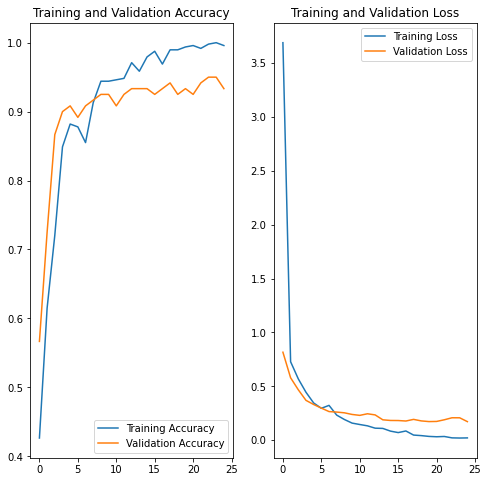

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()